<a href="https://colab.research.google.com/github/luqmanbuang/ASE3103-Computer-Programming/blob/main/Renamed_Main_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

#Importing test dataset
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

df_test_FD001['unit'] += 100


In [4]:
df_combined = pd.concat([df_train_FD001, df_test_FD001]) #combine the two datasets

from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

In [5]:
#split them again
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

df_test_FD001['unit'] -= 100

In [6]:
# finding the max cycles of a unit which is used to find the Remaining Useful Life (RUL)

df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Total Cycles"}, inplace=True)

df_train_FD001['RUL'] = df_train_FD001['Total Cycles'] - df_train_FD001['cycles']

# defining the Health Index, where value of 1 denotes healthy engine and 0 denotes failure
def fractionTTF(dat,q):
    return(dat.RUL[q]-dat.RUL.min()) / (dat.RUL.max()-dat.RUL.min())

fTTFz = []
fTTF = []

for i in range(df_train_FD001['unit'].min(),df_train_FD001['unit'].max()+1):
    dat=df_train_FD001[df_train_FD001.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)

df_train_FD001['Health Index'] = fTTF


In [7]:
# train set
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

# test set
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['Health Index']].values.ravel()

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(50, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
645/645 [==============================] - 0s 623us/step - loss: 0.1153
Epoch 2/50
645/645 [==============================] - 0s 602us/step - loss: 0.0065
Epoch 3/50
645/645 [==============================] - 0s 588us/step - loss: 0.0060
Epoch 4/50
645/645 [==============================] - 0s 590us/step - loss: 0.0060
Epoch 5/50
645/645 [==============================] - 0s 584us/step - loss: 0.0059
Epoch 6/50
645/645 [==============================] - 0s 587us/step - loss: 0.0056
Epoch 7/50
645/645 [==============================] - 0s 594us/step - loss: 0.0056
Epoch 8/50
645/645 [==============================] - 0s 591us/step - loss: 0.0059
Epoch 9/50
645/645 [==============================] - 0s 583us/step - loss: 0.0060
Epoch 10/50
645/645 [==============================] - 0s 600us/step - loss: 0.0054
Epoch 11/50
645/645 [==============================] - 0s 587us/step - loss: 0.0053
Epoch 12/50
645/645 [==============================] - 0s 607us/step - loss: 0.0054
E

In [9]:
score = model.predict(X_test) 
df_test_FD001['Predicted H.I.'] = score

# df_test_FD001

In [10]:
def totcycles(data):
    return(data['cycles'] / (1-data['Predicted H.I.']))
    
df_test_FD001['MaxPredCycles'] = totcycles(df_test_FD001)

# df_test_FD001

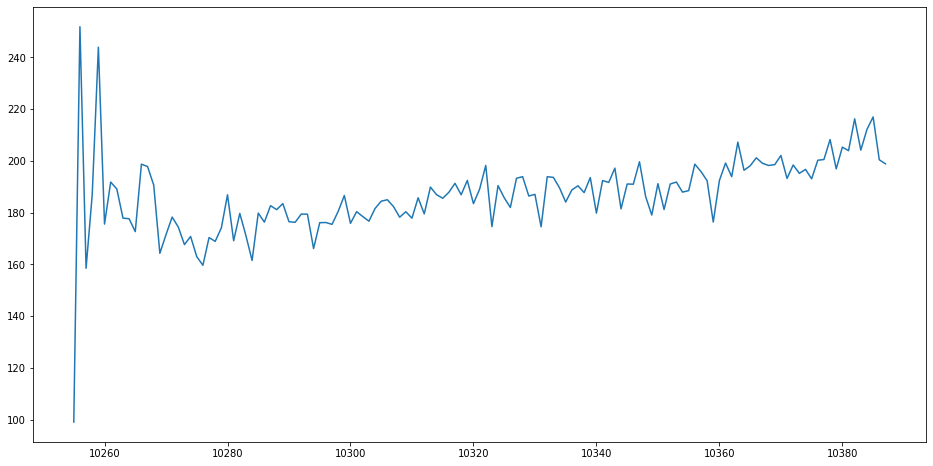

In [11]:
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >0) & (df_test_FD001['unit']==80)])


In [12]:
df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==80)].mean()

187.04908752441406

In [13]:
for i in range(df_test_FD001['unit'].min(),df_test_FD001['unit'].max()+1):
   df_test_FD001.MaxPredCycles[(df_test_FD001['unit'] == i)] = df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==i)].mean()

In [14]:
df_test_FD001['Pred_RUL'] = df_test_FD001.MaxPredCycles * (df_test_FD001['Predicted H.I.'])

# df_test_FD001

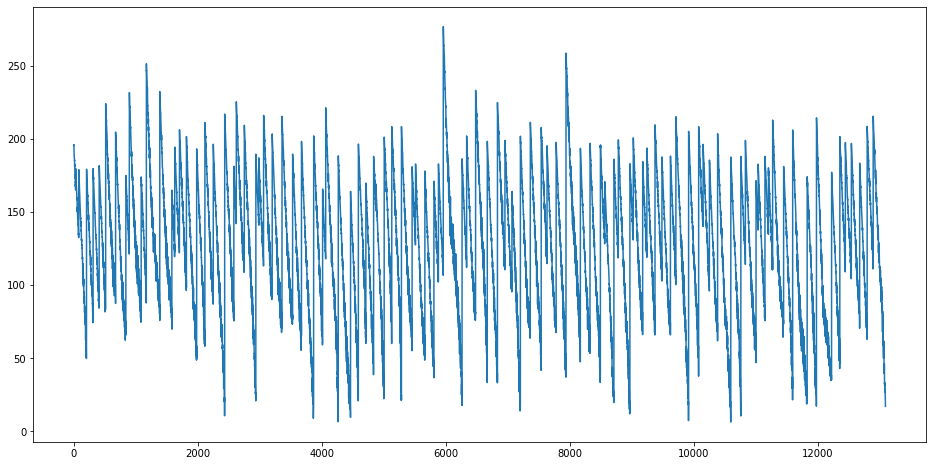

In [15]:
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.Pred_RUL)

In [16]:
df_test_FD001.Pred_RUL[(df_test_FD001['unit']==94)].min()

42.98607635498047

In [17]:
maxpred = []
for i in range(1,101):
  maxpred.append(df_test_FD001.Pred_RUL[(df_test_FD001['unit']==i)].min()) 

len(maxpred)

100

In [18]:
Results = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
Results = Results.dropna(axis=1, how='all')
Results.columns = ["Actual RUL"]

In [19]:
Results = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
Results = Results.dropna(axis=1, how='all')
Results.columns = ["Actual RUL"]
Results = Results.assign(unit=[1 + i for i in range(len(Results))])[['unit'] + Results.columns.tolist()]
Results['Predicted RUL'] = maxpred
Results['Difference'] = Results['Actual RUL'] - Results['Predicted RUL']
Results.set_index('unit')

,Actual RUL,Predicted RUL,Difference
unit,,,
1,112,165.096008,-53.096008
2,98,132.488251,-34.488251
3,69,49.865108,19.134892
4,82,74.396606,7.603394
5,91,84.303223,6.696777
...,...,...,...
96,137,104.392319,32.607681
97,82,70.532997,11.467003
98,59,63.002491,-4.002491


In [20]:
# RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

RMSE = sqrt(mean_squared_error(Results['Actual RUL'], Results['Predicted RUL']))
print("RMSE: ", RMSE)


RMSE:  24.16195152656721


In [22]:
df_test_FD001.drop(['Op1','Op2', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], axis=1, inplace=True)
df_test_FD001

,unit,cycles,Predicted H.I.,MaxPredCycles,Pred_RUL
0,1,1,0.989120,197.840164,195.687576
1,1,2,0.991680,197.840164,196.194138
2,1,3,0.988237,197.840164,195.513046
3,1,4,0.970968,197.840164,192.096497
4,1,5,0.967548,197.840164,191.419830
...,...,...,...,...,...
13091,100,194,0.112954,216.156647,24.415775
13092,100,195,0.114977,216.156647,24.853134
13093,100,196,0.117267,216.156647,25.347948
13094,100,197,0.102948,216.156647,22.252987


In [24]:
df_train_FD001.drop(['Op1','Op2', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], axis=1, inplace=True)
df_train_FD001

,unit,cycles,Total Cycles,RUL,Health Index
0,1,1,192,191,1.000000
1,1,2,192,190,0.994764
2,1,3,192,189,0.989529
3,1,4,192,188,0.984293
4,1,5,192,187,0.979058
...,...,...,...,...,...
20626,100,196,200,4,0.020101
20627,100,197,200,3,0.015075
20628,100,198,200,2,0.010050
20629,100,199,200,1,0.005025
